# Employee Retention


### Background

Employee turnover is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science.

### The Data

We have employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience. Features are as follows:


Columns:
employee_id : id of the employee. Unique by employee per company 

company_id : company id. 

dept : employee dept 

seniority : number of yrs of work experience when hired 

salary: avg yearly salary of the employee during her tenure within the company 

join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 

quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)



### Project Goals

(1) What are the main factors that drive employee churn? Do they make sense? 

(2) What might you be able to do for the company to address employee Churn, what would be follow-up actions?

(3) If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [17]:
### import the data

import pandas as pd
import os

os.chdir('C:\\Users\mattf\Desktop\insight\interview_prep\data_challenges\week5')

data = pd.read_csv('employee_retention_data.csv')


In [18]:
### inspect the data

# check features and types
data.dtypes

# remove employee ID
data = data.drop('employee_id', axis=1)

# set company ID and department as category
data.company_id = data.company_id.astype('category')
data.dept = data.dept.astype('category')

# set join date and quit date to datetime class
data.join_date = pd.to_datetime(data.join_date)
data.quit_date = pd.to_datetime(data.quit_date, errors='coerce') # coerce NaN to NaT

data.head()


,company_id,dept,seniority,salary,join_date,quit_date
0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,4,marketing,14,101000.0,2014-10-13,NaT
3,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,2,data_science,23,276000.0,2011-10-17,2014-08-22


## Feature engineering

The dataset is fairly limited in terms of features. It is possible that combinations of features and/or manipulations of features will prove informative

In [19]:
### feature engineering

import numpy as np

# save a copy with only the base features
dataOrig = data.copy()

In [20]:
# variable to store if they quit or didnt 
data['quitters'] = np.where(pd.isnull(data.quit_date), 1, 0) # 0 = they quit 
dataOrig['quitters'] = np.where(pd.isnull(dataOrig.quit_date), 1, 0) # 0 = they quit 


In [21]:
# salary normalized by average salary within a comapny, across departments
compSalaryDict = data.groupby('company_id').mean().salary.to_dict()
data['salary_compNorm'] = data['salary'] / data['company_id'].map(compSalaryDict)

# salary normalized by the average salary within department types, across companies
deptSalaryDict = data.groupby('dept').mean().salary.to_dict()
data['salary_deptNorm'] = data['salary'] / data['dept'].map(deptSalaryDict)

# salary normalized by the average company department salary
compDeptSalaryDict = data.groupby(['company_id','dept']).mean().salary.to_dict()
data['salary_compDeptNorm'] = data['salary'] / data.set_index(['company_id', 'dept']).index.map(compDeptSalaryDict)

# salary by the number of years of experience before hire
data['salary_expNorm'] = data.salary / data.seniority

In [22]:
# fill in quit_date NaN with date data was collected: 2015/12/13
endDate = pd.to_datetime('2015/12/13')
data.quit_date = data.quit_date.fillna(endDate)

# variable to store how long they worked at the company (units = days)
data['duration'] = (data.quit_date - data.join_date).dt.days

# salary by the number of years they worked at the company
data['salary_durNorm'] = data.salary / data.duration

# variable to mark the year they started
data['join_year'] = data.join_date.dt.year

# variable to mark the year they started
data['join_month'] = data.join_date.dt.month

# we don't want to include the year for quit_date, as *most* of the employees with a 2015 in this column will have not quit yet
# ... and this isn't very meaningful

## Pre-process the data for training models

Before we can investigate the data with a predictive model, the data needs to be in the proper format. This includes:

(1) Scaling numberical columns (de-mean, scale to unit variance)

(2) One-hot encoding categorical columns

In [23]:
## preserve non-transformed data

# target column
y = dataOrig.quitters

# save copy of data before transforms
df_orig = dataOrig.copy()
df = data.copy()

In [24]:
# import pre-processing methods
import sklearn

from sklearn.preprocessing import StandardScaler
scalerOrig = StandardScaler()
scaler = StandardScaler()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder(sparse=False)

In [25]:
## list potential predictive features by type

# original data
orig_num_cols = ['salary', 'seniority']
orig_cat_cols = ['company_id', 'dept']

# feature-engineered data
num_cols = ['salary', 'seniority', 'salary_compNorm', 'salary_deptNorm', 'salary_compDeptNorm',
            'salary_expNorm', 'duration', 'salary_durNorm']
cat_cols = ['company_id', 'dept', 'join_year', 'join_month']


In [26]:
## scale the numberical columns
dataOrig[orig_num_cols] = scalerOrig.fit_transform(dataOrig[orig_num_cols]) # original data
data[num_cols] = scaler.fit_transform(data[num_cols]) # feature-engineered data


In [27]:
## one hot encode the categorical columns

# original data
for col in dataOrig.columns.values:
    for col in orig_cat_cols:
        dle = dataOrig[col]
        le.fit(dle.values)
        dataOrig[col] = le.transform(dataOrig[col])
        
for col in orig_cat_cols:
    dencf = dataOrig[[col]]
    oh.fit(dencf)
    temp = oh.transform(dataOrig[[col]])
    temp = pd.DataFrame(temp,columns=[(col+'_'+str(i)) for i in dencf[col].value_counts().index])
    temp = temp.set_index(dataOrig.index.values)
    dataOrig = pd.concat([dataOrig,temp],axis=1)


# feature-engineered data
for col in data.columns.values:
    for col in cat_cols:
        dle = data[col]
        le.fit(dle.values)
        data[col] = le.transform(data[col])
        
for col in cat_cols:
    dencf = data[[col]]
    oh.fit(dencf)
    temp = oh.transform(data[[col]])
    temp = pd.DataFrame(temp,columns=[(col+'_'+str(i)) for i in dencf[col].value_counts().index])
    temp = temp.set_index(data.index.values)
    data = pd.concat([data,temp],axis=1)
    

In [28]:
## drop redundant / useless features
drop_list_orig = orig_cat_cols + ['join_date', 'quit_date', 'quitters'] 
drop_list = cat_cols + ['join_date', 'quit_date', 'quitters'] 

X_orig = dataOrig.drop(drop_list_orig, axis=1)
X = data.drop(drop_list,axis=1)

## Train models on the two datasets

Here, the results of a Random Forest Classifier are presented. Other models were also tested, but the random forest performed significantly better than a logistic regression, and, though it performed slightly worse than boosted decision trees, it is a simpler model to explain to a company.

In [29]:
## split data into train/test subsets
from sklearn.model_selection import train_test_split

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, y, test_size=0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [30]:
## fit random forest models to the two datasets
from sklearn.ensemble import RandomForestClassifier

forest_orig = RandomForestClassifier()
forest= RandomForestClassifier()

forest_orig.fit(X_orig_train, y_orig_train)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
## prepare to make predications on test set and investigate model metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


# function to get model metrics 
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted)             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted)
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1


# function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="black" if cm[i, j] < thresh else "white", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt



In [32]:
## make predictions on test data
y_orig_pred = forest_orig.predict(X_orig_test)
y_pred = forest.predict(X_test)

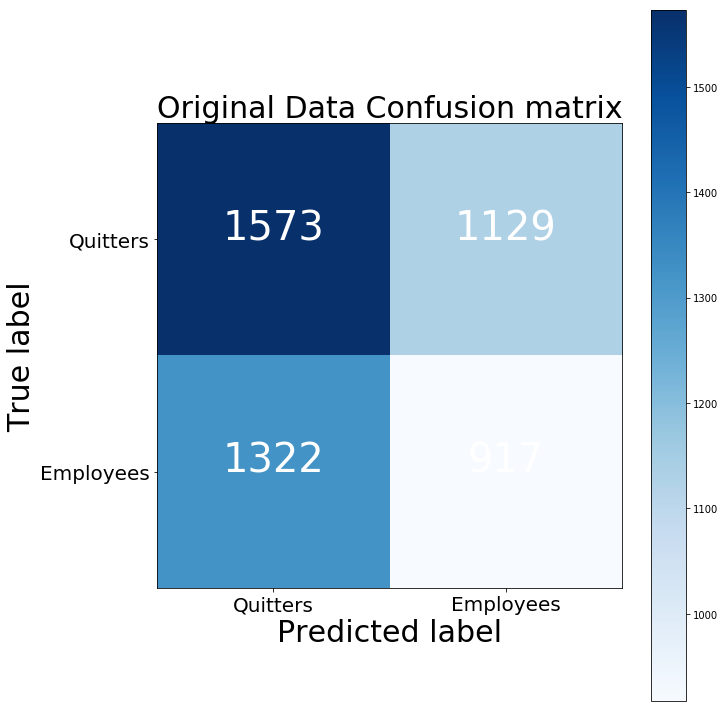

accuracy = 0.504, precision = 0.448, recall = 0.410, f1 = 0.428


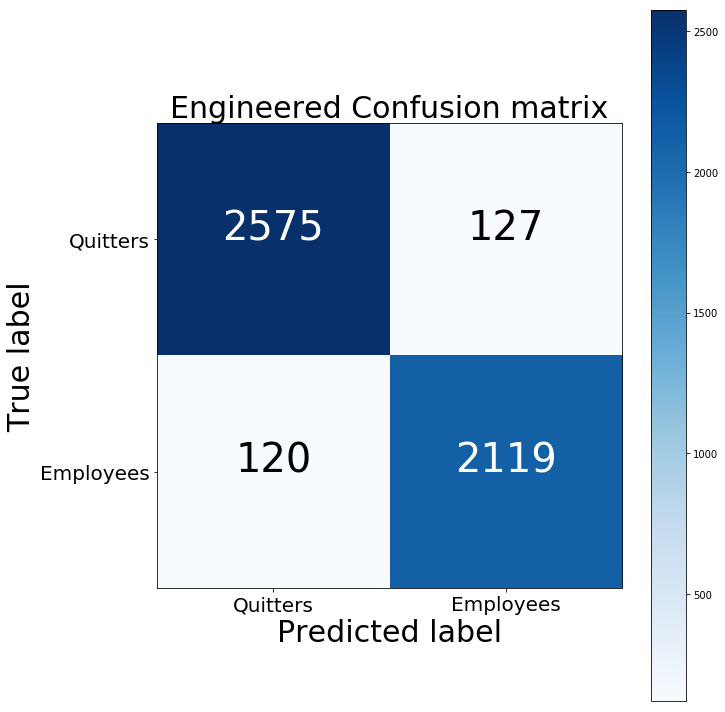

accuracy = 0.950, precision = 0.943, recall = 0.946, f1 = 0.945


In [33]:
## evaluate model performance

# show plots inline
%matplotlib inline

# get metrics and plot confusion matrix for original data model
accuracy_orig, precision_orig, recall_orig, f1_orig = get_metrics(y_orig_test, y_orig_pred)

cm_orig =  confusion_matrix(y_orig_test, y_orig_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_orig, classes=['Quitters','Employees'], normalize=False, title='Original Data Confusion matrix', cmap=plt.cm.Blues)
plt.show()
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_orig, precision_orig, recall_orig, f1_orig))


# get metrics and plot confusion matrix for engineered data model
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

cm =  confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Quitters','Employees'], normalize=False, title='Engineered Confusion matrix', cmap=plt.cm.Blues)
plt.show()
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


## Paramaterize the model

Here, I test a variety of hyperparameters to see if the performance of the model can be significanly improved

In [34]:
## check possible parameters of random forest model
from pprint import pprint

pprint(forest.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [35]:
## create lists of possible parameter values

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [36]:
# Create a grid of those parameter possibilities
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [23]:
### inititate a random grid search, with nested cross-validation for each parameter combination
#
### NOTE - THIS TAKES QUIT SOME TIME - SKIP BELOW TO SEE OUTCOME
#from sklearn.model_selection import RandomizedSearchCV
#
## search across 100 different combinations, and use all available cores
#forest_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
#
## Fit the random search model
#forest_random.fit(X_train, y_train)
#
### NOTE - THIS TAKES QUIT SOME TIME - SKIP BELOW TO SEE OUTCOME

In [24]:
## check best parameters, use that model

#pprint(forest_random.best_params_)
#{'bootstrap': False,
# 'max_depth': 90,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 5,
# 'n_estimators': 400}


In [37]:
## fit a model using the best hyperparamters 

#best_forest = forest_random.best_estimator_
best_forest = RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto', min_samples_leaf=1, 
                                    min_samples_split=5, n_estimators=400) 

best_forest.fit(X_train,y_train)

yb_pred = best_forest.predict(X_test)



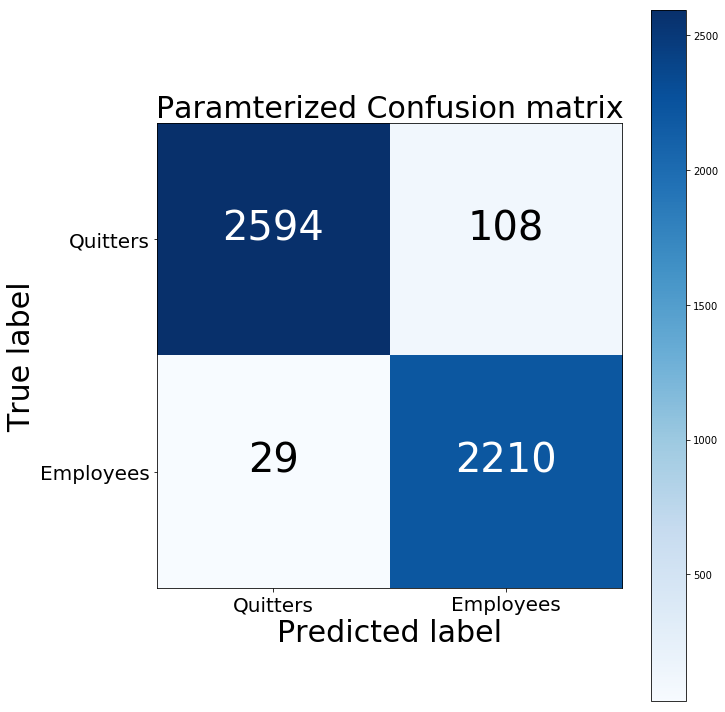

accuracy = 0.972, precision = 0.953, recall = 0.987, f1 = 0.970


In [58]:
# evaluate the model

accuracy_final, precision_final, recall_final, f1_final = get_metrics(y_test, yb_pred)

cm_final =  confusion_matrix(y_test, yb_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_final, classes=['Quitters','Employees'], normalize=False, title='Paramterized Confusion matrix', cmap=plt.cm.Blues)
plt.show()
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_final, precision_final, recall_final, f1_final))


## Visualize the results of the model

Here, I investigate the important features for predicting whether an employee quit or remained with the company, and draw conslusions about what is driving employee churn

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

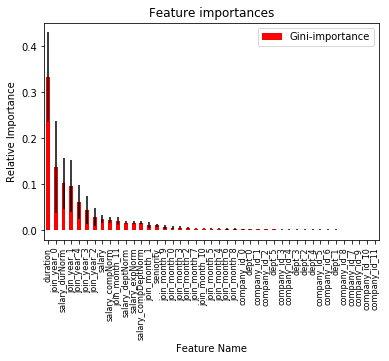

In [38]:
# plot feature importances
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

feats = {} 
for feature, importance in zip(X.columns, importances):
    feats[feature] = importance 

impp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
impp.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', color='r', rot=90, yerr=std[indices], align='center')

plt.title('Feature importances')
plt.xlabel('Feature Name')
plt.ylabel('Relative Importance')
plt.xticks(fontsize=8)

(0, 400)

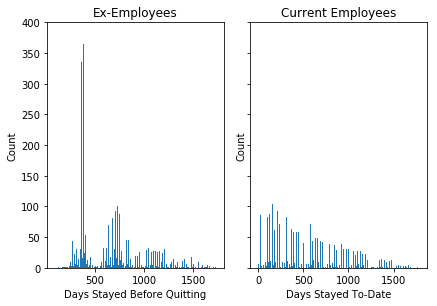

In [39]:
# visualize duration frequencies by quit-class

fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
fig.tight_layout()

ax1.hist(df.loc[df.quitters==0].duration,bins=int(max(df.duration)/2))
ax1.set_title('Ex-Employees')
ax1.set_xlabel('Days Stayed Before Quitting')
ax1.set_ylabel('Count')

ax2.hist(df.loc[df.quitters==1].duration,bins=int(max(df.duration)/2))
ax2.set_title('Current Employees')
ax2.set_xlabel('Days Stayed To-Date')
ax2.set_ylabel('Count')

axes = plt.gca()
axes.set_ylim([0,400])

Text(0.5,0,'Year')

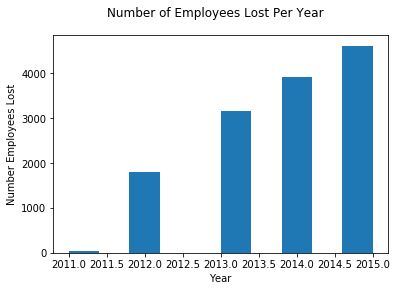

In [40]:
# visualize the number of people who quit each year

fig, (ax1) = plt.subplots(1,1)

fig.suptitle('Number of Employees Lost Per Year')

ax1.hist(df.loc[df.quitters==0].quit_date.dt.year)
ax1.set_ylabel('Number Employees Lost')
ax1.set_xlabel('Year')

Text(0.5,0,'Year of Hire, Current Employees')

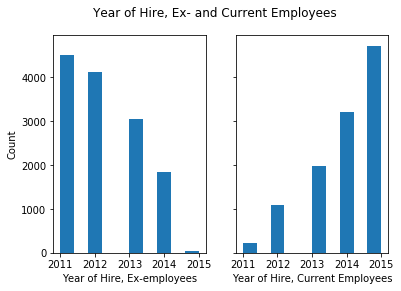

In [41]:
# visualize the year that all ex-employees and current employees were hired

fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)

fig.suptitle('Year of Hire, Ex- and Current Employees')

ax1.hist(df.loc[df.quitters==0].join_date.dt.year)
ax1.set_ylabel('Count')
ax1.set_xlabel('Year of Hire, Ex-employees')

ax2.hist(df.loc[df.quitters==1].join_date.dt.year)
ax2.set_xlabel('Year of Hire, Current Employees')

Text(0.5,0,'Month of Hire, Current Employees')

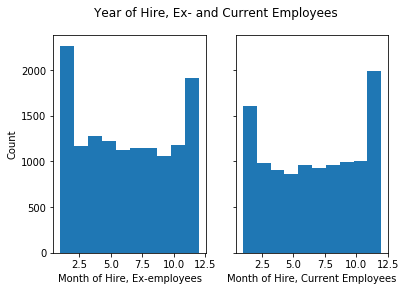

In [42]:
# visualize the month that all ex-employees and current employees were hired

fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)

fig.suptitle('Year of Hire, Ex- and Current Employees')

ax1.hist(df.loc[df.quitters==0].join_date.dt.month)
ax1.set_ylabel('Count')
ax1.set_xlabel('Month of Hire, Ex-employees')

ax2.hist(df.loc[df.quitters==1].join_date.dt.month)
ax2.set_xlabel('Month of Hire, Current Employees')

Text(0.5,0,'Current Employees')

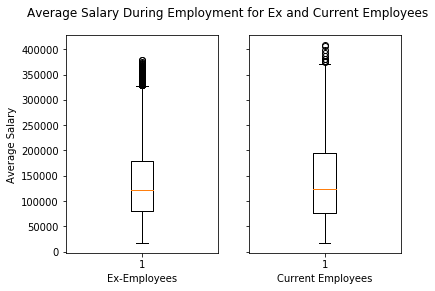

In [33]:
# visualize the absolute salary by quit-class

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True)

fig.suptitle('Average Salary During Employment for Ex and Current Employees')

ax1.boxplot(df.loc[df.quitters==0].salary)
ax1.set_ylabel('Average Salary')
ax1.set_xlabel('Ex-Employees')

ax2.boxplot(df.loc[df.quitters==1].salary)
ax2.set_xlabel('Current Employees')

Text(0.5,0,'Current Employees, Employed < 1 year')

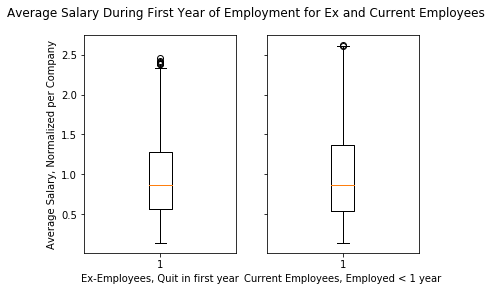

In [43]:
# what are salary differences in the first year employees

newbies = df.loc[df.duration <=365]

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True)

fig.suptitle('Average Salary During First Year of Employment for Ex and Current Employees')

ax1.boxplot(newbies.loc[newbies.quitters==0].salary_compNorm)
ax1.set_ylabel('Average Salary, Normalized per Company')
ax1.set_xlabel('Ex-Employees, Quit in first year')

ax2.boxplot(df.loc[df.quitters==1].salary_compNorm)
ax2.set_xlabel('Current Employees, Employed < 1 year')

## Initial Conclusions / Follow-Up Analysis

#### There are several conclusions to be drawn:

(1) The model's most important features are the duration an employee has been with the company, the year the employee was hired (related), their salary normalized by the duration they've worked there (related), and several other salary normalized (per years of previous experience, per company, per department, etc.)

(2) Of the employees who quit, most tend to quit around the end of their first year, and there is another pulse at the end of their second year.

(3) The company's total churn is increasing every year (which may be in tandem with an increase in company hiring).

(4) There is a clear (and strong) relationship between the year you were hired and your liklihood to still be with the company. This may seem fairly trivial, but the differences between years are quite pronounced. 

(5) There is differential hiring between months (a peak in winter), but the pattern is the same for both current and ex-employees. 

(6) Current employees tend to have slightly higher average salaries than those who quit, both in general and during their first year of employment. 


#### Based on the findings above

(i.e., that churn is concentrated around the first year), and the strong relationship between duration at the company and liklihood to quit, it appears important to look at which features predict not simply IF an employee quit, but how long employees stay with the company 


Thus, I proceed with a linear regression to determine the drivers for employee duration with the company

So a linear regression is probably not the best choice. 
Its not very normal, is bounded on both sides, almost certainly has strange variance properties, etc
I will give it a try anyways, just to get some insight about coefficient weights


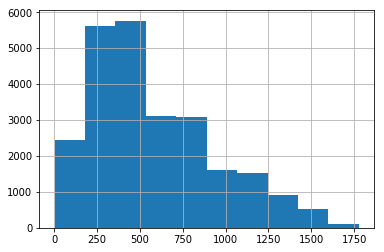

In [65]:
# look at the duration variable

df.duration.hist()

print('So a linear regression is probably not the best choice. \nIts not very normal, is bounded on both sides, almost certainly has strange variance properties, etc')

print('I will give it a try anyways, just to get some insight about coefficient weights')


In [44]:
# look at all the features in our dataset

list(X)

['seniority',
 'salary',
 'salary_compNorm',
 'salary_deptNorm',
 'salary_compDeptNorm',
 'salary_expNorm',
 'duration',
 'salary_durNorm',
 'company_id_0',
 'company_id_1',
 'company_id_2',
 'company_id_3',
 'company_id_4',
 'company_id_5',
 'company_id_6',
 'company_id_7',
 'company_id_8',
 'company_id_9',
 'company_id_11',
 'company_id_10',
 'dept_0',
 'dept_3',
 'dept_1',
 'dept_5',
 'dept_4',
 'dept_2',
 'join_year_1',
 'join_year_3',
 'join_year_2',
 'join_year_4',
 'join_year_0',
 'join_month_9',
 'join_month_3',
 'join_month_2',
 'join_month_7',
 'join_month_5',
 'join_month_4',
 'join_month_6',
 'join_month_8',
 'join_month_10',
 'join_month_0',
 'join_month_1',
 'join_month_11']

In [71]:
## Set up the datasets

# keep only data for employees which have been at the company for around 3 years or less -
# we want to know what predicts the difference b/w being a churning at the 1st/2nd year or not 
ylr = X.duration[df.duration<=750]
Xl = X.loc[df.duration<=750]

# drop certain columns from the analysis
lr_dur_cols =['duration', 'salary_durNorm'] # bc we don't want the target variable in the predicting data
lr_drop_cols = lr_dur_cols + ['join_year_1', 'join_year_2', 'join_year_3', 'join_year_4', 'join_year_0'] # drop the years, related to duration
Xlr = Xl.drop(lr_drop_cols, axis=1)


Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(Xlr, ylr, test_size=0.2)


In [72]:
# Fit a linear model

from sklearn.linear_model import LinearRegression

lr = LinearRegression(normalize=False)
lr.fit(Xlr_train,ylr_train,sample_weight=None)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
# Evaluate the model 

lr_pred = lr.predict(Xlr_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('\nMean absolute error: %.2f' % mean_absolute_error(ylr_test, lr_pred),'days')

print('\nVariance score: %.2f' % r2_score(ylr_test, lr_pred))


Mean absolute error: 0.41 days

Variance score: 0.06


        coef          varname
1  -0.064777           salary
2   0.054779  salary_compNorm
3   0.058565  salary_deptNorm
7  -0.048154     company_id_1
14 -0.048633     company_id_8
16  0.054274    company_id_11
17  0.189787    company_id_10
24  0.178458     join_month_9
25  0.147849     join_month_3
26  0.094119     join_month_2
27  0.089508     join_month_7
28  0.045131     join_month_5
30 -0.054824     join_month_6
31 -0.119429     join_month_8
32 -0.103688    join_month_10
33 -0.149054     join_month_0
34 -0.227461     join_month_1
35  0.123194    join_month_11


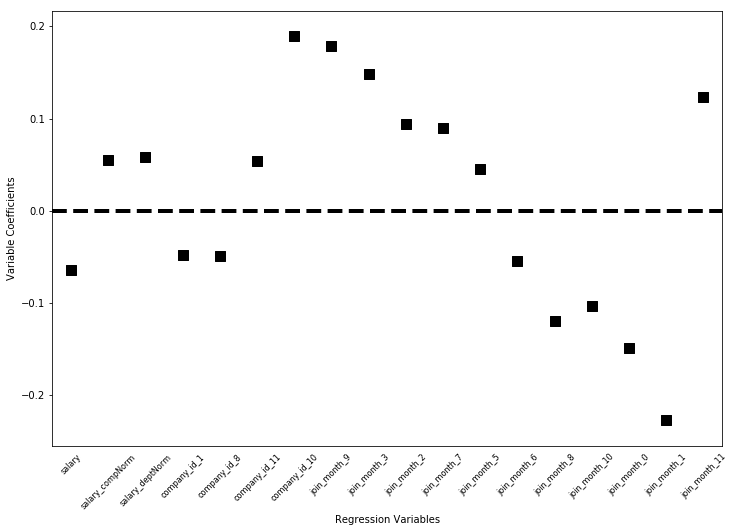

In [76]:
# plot the important regression coefficients

coefs_df = pd.DataFrame({'coef': lr.coef_,
                        'varname': list(Xlr)
                       })

medCoef = abs(coefs_df.coef).median()
coef_df = coefs_df.loc[abs(coefs_df.coef) >= medCoef]
coef_df = coef_df.loc[abs(coef_df.coef) < 200]


print(coef_df)

fig, ax = plt.subplots(figsize=(12, 8))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', legend=False)
ax.set_ylabel('Variable Coefficients')
ax.set_xlabel('Regression Variables')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(coef_df.varname, 
                       rotation=45, fontsize=8)

# Summary and Conclusions


### Summary of Analysis

As a part of this analysis, the following actions were taken:

(1) I engineered a variety of features relating salary to companies, departments, experience, and duration with the company.

(2) I engineered time-related features, including: year hired, month hired, duration with the company

(3) I fit a variety of models to predict whether an employee was still with the company. A random forest was the best compromise between performance and interprability.

(4) A tuned random forest was able to achieve high accuracy (97%), precision (95%), and recall (99%) on the holdout test data. Thus, I have high confidence in the model.


(5) By looking at the feature importances of the model, I was able to gain insights about the important factors predicting whether or not an employee was retained. 

(6) After investigating these features in more details, it seemed important to look at the factors which determined the length of an employee's time at the company.

(7) A linear regression was used to predict employee duration with a company. The model had a very poor variance score (0.06).

(8) Coefficients of the model were used to determine the important factors influencing an employee's duration with a company.



### Addressing the stated goals of the project

#####  What are the main factors that drive employee churn? Do they make sense? 

(1) The most important factor predicting churn is how long the employee has already worked for the company. Employees are very likely to quit after their first year, and then there is a second pulse of churn after employees' second years. When these variables are removed from the lienar regression, it loses almost all of its predictive power 

(2) Though not nearly as important, the hiring month seems relevant. Employee's hired in fall / winter months are more likely to quit the company relatively early, compared to employees hired in spring / summer months. 

(3) While overall salary has a negative association with duration at the company, your salary normalized by the average within your company and department has a positive relationship. 


#### What might you be able to do for the company to address employee Churn, what would be follow-up actions?

(1) Companies should make an effort to find out why so many customers are leaving after only a single year. Is there a problem with culture? Is there something wrong with the hiring process itself? Surveys and evaluations should be administered for first-year employees. 

(2) Companies should make an effort to find out why their fall/winter hires are more likely to leave the company early. Are they moving from out of town and finding the first few months of a jew job mixed with Boston weather unbearable? Since they're hiring more total people in the winter months (January/December), it is possible that employees hired then are getting less attention than those hired at other times of the year. They sould try to even out their hiring rate across the year. 

(3) Companies should make an effort to balance salary within the company and within company department's, whenever possible.

(4) People should ask company 10 about their policies, as it seems their employees tend to have much longer durations at the company than average. 

##### If you could add to this data set just one variable that could help explain employee churn, what would that be?

If I could have one variable, it would be a text string, with the employee describing why they left the company. Using this, I could determine what common factors mentioned in the text were most common. This would be substantial more informative than the quantitive measures given in this dataset, as most of the reasons people leave a company can not be quantified so simply (e.g., their boss, their coworkers, the work itself, etc.)

